In [70]:
from FastSurfer.FastSurferCNN.data_loader.load_neuroimaging_data import load_and_conform_image
import nibabel as nib
from nibabel.processing import conform
import pandas as pd
import matplotlib.pyplot as plt

from PIL import ImageFilter
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from tqdm import tqdm
import os
import random
from pathlib import Path
import joblib

In [274]:
class MultiCropDataset():
    def __init__(
        self,
        samples,
        size_crops,
        nmb_crops,
        min_scale_crops,
        max_scale_crops,
        size_dataset=-1,
        return_index=False,
    ):
        self.samples = samples
        assert len(size_crops) == len(nmb_crops)
        assert len(min_scale_crops) == len(nmb_crops)
        assert len(max_scale_crops) == len(nmb_crops)
        if size_dataset >= 0:
            self.samples = self.samples[:size_dataset]
        self.return_index = return_index

        #color_transform = [get_color_distortion(), PILRandomGaussianBlur()]
        #mean = [0.485, 0.456, 0.406]
        mean = [0.485]
        #std = [0.228, 0.224, 0.225]
        std = [0.228]
        trans = []
        for i in range(len(size_crops)):
            randomresizedcrop = transforms.RandomResizedCrop(
                size_crops[i],
                scale=(min_scale_crops[i], max_scale_crops[i]),
            )
            trans.extend([transforms.Compose([
                randomresizedcrop,
                transforms.RandomHorizontalFlip(p=0.5),
                #transforms.Compose(color_transform),
                transforms.ToPILImage(),
                PILRandomGaussianBlur(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)])
            ] * nmb_crops[i])
        self.trans = trans

    def __getitem__(self, index):
        images, _ = self.samples[index]
        multi_crops = list(map(lambda trans: [trans(torch.unsqueeze(torch.Tensor(image),0)) for image in images], self.trans))
        if self.return_index:
            return index, multi_crops
        return multi_crops


class PILRandomGaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image. Take the radius and probability of
    application as the parameter.
    This transform was used in SimCLR - https://arxiv.org/abs/2002.05709
    """

    def __init__(self, p=0.5, radius_min=0.01, radius_max=0.2):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = np.random.rand() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )


def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

In [338]:
train_dataset = MultiCropDataset(
        train_loader,
        [256],
        [2],
        [50],
        [100],
    )

In [353]:
for t in train_dataset:
    print(len(t[0][0]))

1
1
1


In [4]:
def fix_random_seeds(seed=31):
    """
    Fix random seeds.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

## Data Processing and Loading

In [64]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image, _ = joblib.load(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [65]:
data = CustomImageDataset('data/labels.csv', 'data/Processed/')

In [147]:
df_info = pd.read_csv('data/info.csv')

ORDER_MAP = {'Artiodactyla':1,
 'Carnivora':2,
 'Chiroptera':3,
 'Eulipotyphla':4,
 'Hyracoidea':5,
 'Lagomorpha':6,
 'Marsupialia':7,
 'Perissodactyla':8,
 'Primates':9,
 'Rodentia':10,
 'Scandentia':11,
 'Xenarthra':12}

def process_raw_image(datadir, f, order):
    if order.empty:
        order = df_info[df_info.Filename.str.fullmatch(f.stem[:f.stem.find('_')])].Order.drop_duplicates()
    if order.size != 1:
        print(f)
        print(order)
        return ''
    try:
        img = conform(nib.load(f))
    except:
        print(f)
        return ''
    img = np.array(img.get_fdata())
    img += abs(img.min())
    img /= img.max()
    joblib.dump([img,order], datadir + 'Processed/' + f.stem + '.joblib')
    return f'{f.stem}.joblib,{ORDER_MAP[order.values[0]]}\n'

def process_raw_images(datadir='data/', order=pd.Series(dtype=str)):
    annotations = 'filename,order\n'
    for f in tqdm((Path(datadir)/'MRI').iterdir()):
        annotations += process_raw_image(datadir, f, order)
    with open(Path(datadir)/'labels.csv', 'w') as f:
        f.write(annotations)
        
def load_processed(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'Processed').iterdir():
        train_loader.append(joblib.load(f))
    return train_loader

def load_raw(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'MRI').iterdir():
        order = df_info[df_info.Filename.str.contains(f.stem[:f.stem.find('_')-1])].Order.drop_duplicates()
        if order.size > 1:
            print(order)
            continue
        img = nib.load(f).get_fdata()
        train_loader.append([img, order])
    return train_loader

In [149]:
process_raw_images(datadir='f:/Data/OpenNeuro/ds004114-download/', order=pd.Series(['Rodentia']))

185it [01:57,  1.46it/s]

f:\Data\OpenNeuro\ds004114-download\MRI\sub-0101703_ses-2_T2w.nii.gz


534it [05:48,  1.47it/s]

f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104700_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104700_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104701_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104701_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104702_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104702_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104703_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104703_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104704_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104704_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104705_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104705_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104706_ses-1_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-download\MRI\sub-0104706_ses-2_T2w.nii.gz
f:\Data\OpenNeuro\ds004114-downloa

751it [07:53,  1.59it/s]


In [150]:
data = load_processed('f:/Data/OpenNeuro/ds004114-download/')

MemoryError: Unable to allocate 128. MiB for an array with shape (16777216,) and data type float64

In [151]:
del data

In [106]:
process_raw_image('data/', Path('data/MRI/DikDik_T2.nii'))

'DikDik_T2.joblib,1\n'

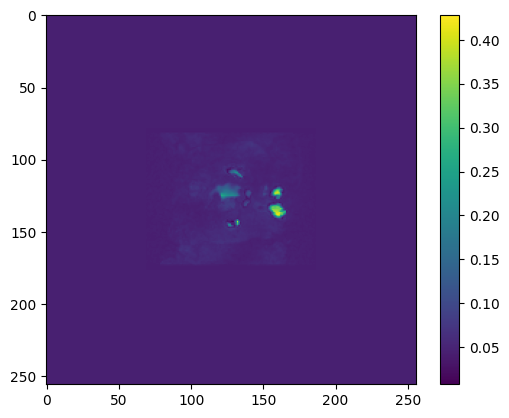

In [60]:
plt.imshow(img[:,:,100])
plt.colorbar()
plt.show()

In [333]:
train_loader = load_raw()

## SWaV

In [8]:
def train(train_loader, model, optimizer, epoch, lr_schedule, queue):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train()
    use_the_queue = False

    end = time.time()
    for it, inputs in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # update learning rate
        iteration = epoch * len(train_loader) + it
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_schedule[iteration]

        # normalize the prototypes
        with torch.no_grad():
            w = model.module.prototypes.weight.data.clone()
            w = nn.functional.normalize(w, dim=1, p=2)
            model.module.prototypes.weight.copy_(w)

        # ============ multi-res forward passes ... ============
        embedding, output = model(inputs)
        embedding = embedding.detach()
        bs = inputs[0].size(0)

        # ============ swav loss ... ============
        loss = 0
        for i, crop_id in enumerate(args.crops_for_assign):
            with torch.no_grad():
                out = output[bs * crop_id: bs * (crop_id + 1)].detach()

                # time to use the queue
                if queue is not None:
                    if use_the_queue or not torch.all(queue[i, -1, :] == 0):
                        use_the_queue = True
                        out = torch.cat((torch.mm(
                            queue[i],
                            model.module.prototypes.weight.t()
                        ), out))
                    # fill the queue
                    queue[i, bs:] = queue[i, :-bs].clone()
                    queue[i, :bs] = embedding[crop_id * bs: (crop_id + 1) * bs]

                # get assignments
                q = distributed_sinkhorn(out)[-bs:]

            # cluster assignment prediction
            subloss = 0
            for v in np.delete(np.arange(np.sum(args.nmb_crops)), crop_id):
                x = output[bs * v: bs * (v + 1)] / args.temperature
                subloss -= torch.mean(torch.sum(q * F.log_softmax(x, dim=1), dim=1))
            loss += subloss / (np.sum(args.nmb_crops) - 1)
        loss /= len(args.crops_for_assign)

        # ============ backward and optim step ... ============
        optimizer.zero_grad()
        if args.use_fp16:
            with apex.amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        # cancel gradients for the prototypes
        if iteration < args.freeze_prototypes_niters:
            for name, p in model.named_parameters():
                if "prototypes" in name:
                    p.grad = None
        optimizer.step()

        # ============ misc ... ============
        losses.update(loss.item(), inputs[0].size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        if args.rank ==0 and it % 50 == 0:
            logger.info(
                "Epoch: [{0}][{1}]\t"
                "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Data {data_time.val:.3f} ({data_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t"
                "Lr: {lr:.4f}".format(
                    epoch,
                    it,
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    lr=optimizer.optim.param_groups[0]["lr"],
                )
            )
    return (epoch, losses.avg), queue

@torch.no_grad()
def distributed_sinkhorn(out):
    Q = torch.exp(out / args.epsilon).t() # Q is K-by-B for consistency with notations from our paper
    B = Q.shape[1] * args.world_size # number of samples to assign
    K = Q.shape[0] # how many prototypes

    # make the matrix sums to 1
    sum_Q = torch.sum(Q)
    dist.all_reduce(sum_Q)
    Q /= sum_Q

    for it in range(args.sinkhorn_iterations):
        # normalize each row: total weight per prototype must be 1/K
        sum_of_rows = torch.sum(Q, dim=1, keepdim=True)
        dist.all_reduce(sum_of_rows)
        Q /= sum_of_rows
        Q /= K

        # normalize each column: total weight per sample must be 1/B
        Q /= torch.sum(Q, dim=0, keepdim=True)
        Q /= B

    Q *= B # the colomns must sum to 1 so that Q is an assignment
    return Q.t()

In [12]:
img = train_loader[0]

In [158]:
img = nib.load('f:/Data/OpenNeuro/ds004215-download/MRI/sub-ON01802_ses-01_acq-CUBE_T2w.nii.gz').get_fdata()

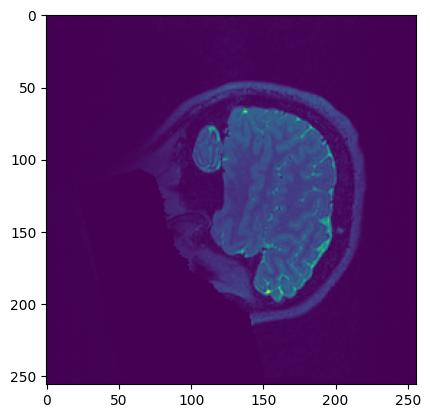

In [161]:
plt.imshow(img[150])
plt.show()

In [160]:
img.shape

(204, 256, 256)